In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


In [3]:
path = '../data/ml-1m/'

movies = pd.read_csv(path + 'movies.dat', sep = '::', engine = 'python', encoding = 'latin-1', names = ['movie_id', 'title', 'genres'])
ratings = pd.read_csv(path + 'ratings.dat', sep = '::', engine = 'python', encoding = 'latin-1', names = ['user_id', 'movie_id', 'rating', 'time'])
users = pd.read_csv(path + 'users.dat', sep = '::', engine = 'python', encoding = 'latin-1', names = ['user_id', 'gender', 'age', 'occupation', 'zipcode'])


In [4]:
pivot_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
original_rating_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')

n_users, n_movies = pivot_matrix.values.shape
pivot_notna = pivot_matrix.notna()

In [5]:
import random
random.seed(42)
def train_test_split(matrix, ratio):
    true_indices = np.argwhere(matrix)

    num_test = int(len(true_indices) * ratio)
    np.random.shuffle(true_indices)

    test_indices = true_indices[:num_test]
    train_indices = true_indices[num_test:]

    train_dataset, test_dataset = np.zeros_like(matrix), np.zeros_like(matrix)

    for i in range(len(test_indices)):
        row_idx, column_idx = test_indices[i]
        test_dataset[row_idx, column_idx] = 1
    
    for i in range(len(train_indices)):
        row_idx, column_idx = train_indices[i]
        train_dataset[row_idx, column_idx] = 1

    return train_dataset, test_dataset

bin_train_data, bin_test_data = train_test_split(pivot_notna, 0.1)

In [6]:
train_data, test_data = pivot_matrix * bin_train_data, pivot_matrix * bin_test_data

In [7]:
corr = train_data.corr().values

In [8]:
# To derive Baseline estimates
## Except the NaN Value
overall_mean, user_mean, moive_mean = np.nanmean(train_data.values) , train_data.mean(axis=1), train_data.mean()

In [9]:
train_data[train_data.isnull()] = -1
train_data = torch.FloatTensor(train_data.values)
test_data[test_data.isnull()] = -1
test_data = torch.FloatTensor(test_data.values)

In [10]:
train_data[np.where(train_data == 0)] = -1
test_data[np.where(test_data == 0)] = -1


# Preliminaries

## Baseline estimates


In [19]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self, prediction, rating_matrix):
        non_zero_mask = (rating_matrix != -1).type(torch.FloatTensor)
        diff = (prediction - rating_matrix)**2
        prediction_error = (torch.sum(diff*non_zero_mask)/non_zero_mask.sum()) ** (1/2)
        return prediction_error.detach().numpy()
    
RMSE = RMSELoss()

In [17]:
class Baseline(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, lam_u=2e-3):
        super().__init__()
        self.lam_u = lam_u
        self.overall_matrix = overall * torch.ones(n_users, n_movies)
        self.user_bias = nn.Parameter(torch.randn(n_users))
        self.movie_bias = nn.Parameter(torch.randn(n_movies))
        self.matrix = matrix
        self.non_zero_mask = (matrix != -1).type(torch.FloatTensor)

    def forward(self):
        user_bias_matrix = self.user_bias[:, None].expand(n_users, n_movies)
        movie_bias_matrix = self.movie_bias[None, :].expand(n_users, n_movies)
        baseline_matrix = self.overall_matrix + user_bias_matrix + movie_bias_matrix
        
        return baseline_matrix
    
    def loss(self, prediction):
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.non_zero_mask)
        l2_reg = self.lam_u * (self.user_bias.norm(p=2) + self.movie_bias.norm(p=2))
        total_loss = prediction_error + l2_reg
        
        return total_loss
    

In [80]:
baseline = Baseline(overall_mean, train_data, n_users, n_movies)
optimizer = torch.optim.SGD(baseline.parameters(), lr=5e-5)
bl_train_rmse, bl_test_rmse = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = baseline()
    loss = baseline.loss(out)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    if step % 50 == 0:
        bl_train_rmse.append(RMSE(out,train_data))
        bl_test_rmse.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 3011201.500
Step 50, 986171.812
Step 100, 839768.000
Step 150, 790732.625
Step 200, 767475.875
Step 250, 754455.250
Step 300, 746418.938
Step 350, 741129.812
Step 400, 737486.188
Step 450, 734887.750
Step 500, 732983.312


In [81]:
bl_test_rmse[-1]

array(0.910136, dtype=float32)

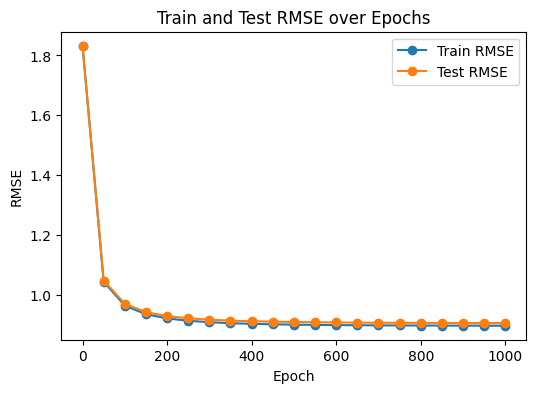

In [48]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, bl_train_rmse, label='Train RMSE', marker='o')
plt.plot(epochs, bl_test_rmse, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [49]:
# 모델의 state_dict 출력
print("baseline's state_dict:")
for param_tensor in baseline.state_dict():
    print(param_tensor, "\t", baseline.state_dict()[param_tensor].size())

print()

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

baseline's state_dict:
user_bias 	 torch.Size([6040])
movie_bias 	 torch.Size([3706])

Optimizer's state_dict:
state 	 {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}
param_groups 	 [{'lr': 5e-05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]


## Neighborhood Models

### Weighted Average Model

In [82]:
def get_rated_both_items(matrix):
    cnt = 0 
    non_zero_mask = (matrix != -1).type(torch.FloatTensor)
    return torch.matmul(non_zero_mask.T, non_zero_mask)

get_rated_both_items(train_data)

tensor([[1884.,  388.,  230.,  ...,   29.,    9.,  134.],
        [ 388.,  625.,  126.,  ...,   15.,    4.,   56.],
        [ 230.,  126.,  429.,  ...,   11.,    3.,   43.],
        ...,
        [  29.,   15.,   11.,  ...,   50.,    6.,   31.],
        [   9.,    4.,    3.,  ...,    6.,   36.,   22.],
        [ 134.,   56.,   43.,  ...,   31.,   22.,  333.]])

In [83]:
corr 

array([[ 1.        , -0.01562298, -0.03167486, ..., -0.09652342,
        -0.12439981,  0.24931217],
       [-0.01562298,  1.        , -0.02789282, ...,  0.14525461,
         0.57522374,  0.2630801 ],
       [-0.03167486, -0.02789282,  1.        , ...,  0.4675719 ,
                nan,  0.1146396 ],
       ...,
       [-0.09652342,  0.14525461,  0.4675719 , ...,  1.        ,
         0.28867513,  0.36990743],
       [-0.12439981,  0.57522374,         nan, ...,  0.28867513,
         1.        ,  0.19904421],
       [ 0.24931217,  0.2630801 ,  0.1146396 , ...,  0.36990743,
         0.19904421,  1.        ]])

In [52]:
def get_shrunk_coefficient(p_coefficient, n_ij, lam_u):
    shrunk_coefficient = (n_ij / (n_ij + lam_u)) * p_coefficient 
    shrunk_coefficient[torch.isnan(shrunk_coefficient)] = 0
    shrunk_coefficient.fill_diagonal_(0)
    return shrunk_coefficient

shrunk_coeff = get_shrunk_coefficient(corr, get_rated_both_items(train_data), 100)

In [53]:
shrunk_coeff

tensor([[ 0.0000, -0.0124, -0.0221,  ..., -0.0217, -0.0103,  0.1428],
        [-0.0124,  0.0000, -0.0156,  ...,  0.0189,  0.0221,  0.0944],
        [-0.0221, -0.0156,  0.0000,  ...,  0.0463,  0.0000,  0.0345],
        ...,
        [-0.0217,  0.0189,  0.0463,  ...,  0.0000,  0.0163,  0.0875],
        [-0.0103,  0.0221,  0.0000,  ...,  0.0163,  0.0000,  0.0359],
        [ 0.1428,  0.0944,  0.0345,  ...,  0.0875,  0.0359,  0.0000]],
       dtype=torch.float64)

In [54]:
def get_neighborhood(shrunkage, k_neighborhood):
    topk_indices = torch.topk(shrunkage, k = k_neighborhood, dim=1).indices
    topk_matrix = torch.zeros(n_movies, n_movies)
    for i in range(topk_indices.size(0)):
        topk_matrix[i, topk_indices[i]] = 1
    topk_s_coeff = torch.mul(topk_matrix, shrunkage)
    topk_sigma = topk_s_coeff / torch.sum(topk_s_coeff, axis=1).unsqueeze(1)
    topk_sigma[torch.isnan(topk_sigma)] = 0

    return topk_matrix, topk_sigma

In [59]:
topk_matrix, topk_sigma = get_neighborhood(shrunk_coeff, 300)

In [87]:
class Neighborhood(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, top_k = 10, lam_u=2e-3):
        super().__init__()
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.matrix = matrix
        self.lam_u = lam_u
        

    def forward(self):
        baseline_matrix = self.baseline()
        diff_matrix = self.matrix - baseline_matrix
        prediction = baseline_matrix + torch.matmul(diff_matrix.double(), topk_sigma.T)
    
        return prediction

    def loss(self, prediction):
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.baseline.non_zero_mask)
        l2_reg = self.lam_u * (torch.sum(self.baseline.user_bias.norm(p=2)) + torch.sum(self.baseline.movie_bias.norm(p=2)))
        total_loss = prediction_error + l2_reg
        
        return total_loss

In [88]:
corngbr = Neighborhood(overall_mean, train_data, n_users, n_movies)
optimizer = torch.optim.SGD(corngbr.parameters(), lr=5e-5)

corngbr_train_rsme, corngbr_test_rmse = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = corngbr()
    loss = corngbr.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        corngbr_train_rsme.append(RMSE(out,train_data))
        corngbr_test_rmse.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 14670530.642
Step 50, 8081401.534
Step 100, 7553055.868
Step 150, 7318214.706
Step 200, 7189375.484
Step 250, 7111749.793
Step 300, 7062232.971
Step 350, 7029336.603
Step 400, 7006777.450
Step 450, 6990894.551
Step 500, 6979454.473


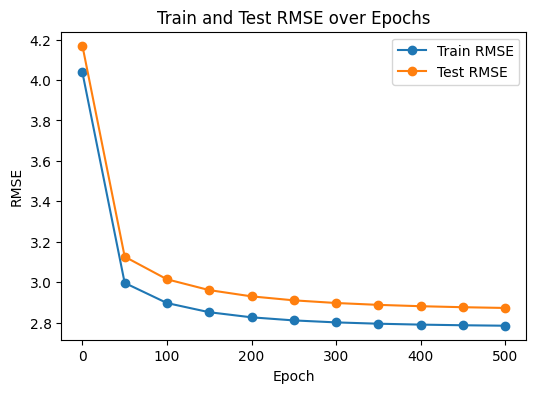

In [165]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, corngbr_train_rsme, label='Train RMSE', marker='o')
plt.plot(epochs, corngbr_test_rmse, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [166]:
corngbr_test_rmse[-1]

array(2.87231607)

## Latent Factor Models

### Regularized SVD

In [73]:
class SVD(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, dim = 10,  lam_u=0.01):
        super().__init__()
        self.lam_u = lam_u
        self.matrix = matrix
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.user_features = nn.Parameter(torch.randn(n_users, dim))
        self.movie_features = nn.Parameter(torch.randn(n_movies, dim))
        self.non_zero_mask = (matrix != -1).type(torch.FloatTensor)
    
    def forward(self):
        baseline_matrix = self.baseline()
        feature_matrix = torch.matmul(self.user_features, self.movie_features.t())
        prediction = baseline_matrix + feature_matrix

        return prediction
    
    def loss(self, prediction):
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.non_zero_mask)
        u_regularization = self.lam_u * (torch.sum(self.baseline.user_bias.norm(p=2)) + torch.sum(self.baseline.movie_bias.norm(p=2)) + torch.sum(self.user_features.norm(p=2)) + torch.sum(self.movie_features.norm(p=2)))
        
        return prediction_error + u_regularization 

In [90]:
svd = SVD(overall_mean, train_data, n_users, n_movies)
optimizer = torch.optim.SGD(svd.parameters(), lr=5e-5)

svd_train_rmse_dim10, svd_test_rmse_dim10 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = svd()
    loss = svd.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        svd_train_rmse_dim10.append(RMSE(out,train_data))
        svd_test_rmse_dim10.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 12398379.000
Step 50, 1404025.125
Step 100, 1002730.312
Step 150, 873804.188
Step 200, 812829.125
Step 250, 778172.625
Step 300, 756160.062
Step 350, 741069.312
Step 400, 730113.125
Step 450, 721783.562
Step 500, 715197.000


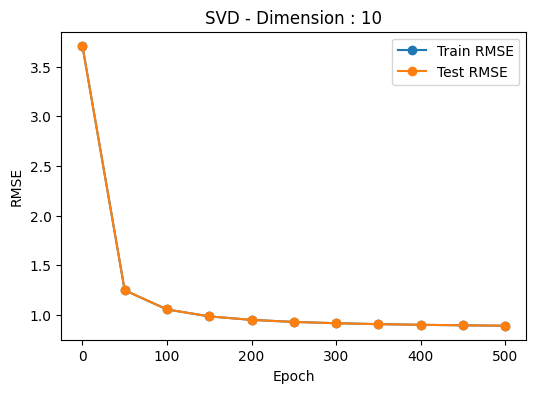

In [161]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, svd_train_rmse_dim10, label='Train RMSE', marker='o')
plt.plot(epochs, svd_train_rmse_dim10, label='Test RMSE', marker='o')

plt.title('SVD - Dimension : 10')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [93]:
svd_test_rmse_dim10[-1]

array(0.9638888, dtype=float32)

In [172]:
svd = SVD(overall_mean, train_data, n_users, n_movies, dim=50)
optimizer = torch.optim.SGD(svd.parameters(), lr=5e-5)

svd_train_rmse_dim50, svd_test_rmse_dim50 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = svd()
    loss = svd.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(svd.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        svd_train_rmse_dim50.append(RMSE(out,train_data))
        svd_test_rmse_dim50.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 47391356.000
Step 50, 2598376.000
Step 100, 1356164.875
Step 150, 999030.938
Step 200, 843276.188
Step 250, 760132.500
Step 300, 709825.625
Step 350, 676598.000
Step 400, 653151.938
Step 450, 635716.625
Step 500, 622178.250


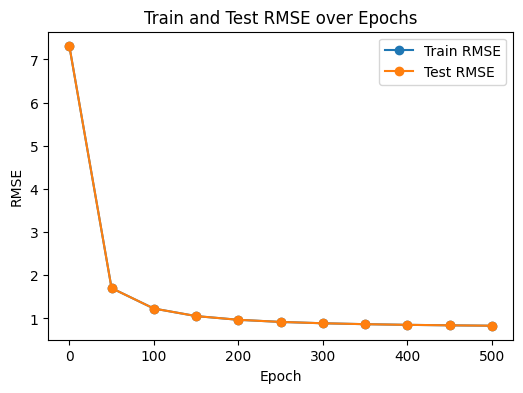

In [94]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, svd_train_rmse_dim50, label='Train RMSE', marker='o')
plt.plot(epochs, svd_train_rmse_dim50, label='Test RMSE', marker='o')

plt.title('SVD - Dimension : 50')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [97]:
svd_test_rmse_dim50

[array(7.313771, dtype=float32),
 array(2.246018, dtype=float32),
 array(1.8338333, dtype=float32),
 array(1.6739609, dtype=float32),
 array(1.5892963, dtype=float32),
 array(1.5372857, dtype=float32),
 array(1.5024114, dtype=float32),
 array(1.4776396, dtype=float32),
 array(1.4593118, dtype=float32),
 array(1.4453346, dtype=float32),
 array(1.4344225, dtype=float32)]

In [96]:
svd = SVD(overall_mean, train_data, n_users, n_movies, dim=100)
optimizer = torch.optim.SGD(svd.parameters(), lr=5e-5)

svd_train_rmse_dim100, svd_test_rmse_dim100 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = svd()
    loss = svd.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        svd_train_rmse_dim100.append(RMSE(out,train_data))
        svd_test_rmse_dim100.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 93027648.000
Step 50, 3391382.750
Step 100, 1476643.125
Step 150, 988633.938
Step 200, 790387.500
Step 250, 688840.812
Step 300, 628937.500
Step 350, 590047.375
Step 400, 562969.125
Step 450, 543069.750
Step 500, 527798.250


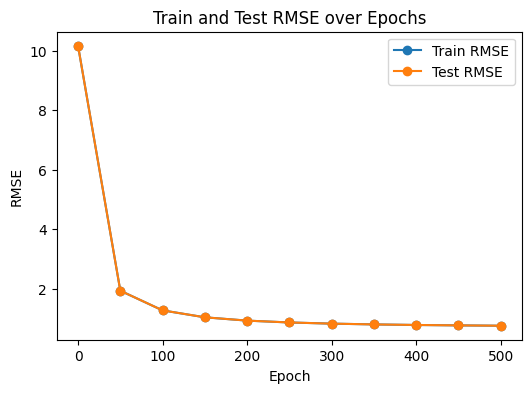

In [98]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, svd_train_rmse_dim100, label='Train RMSE', marker='o')
plt.plot(epochs, svd_train_rmse_dim100, label='Test RMSE', marker='o')

plt.title('SVD - Dimension : 100')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [162]:
svd_test_rmse_dim100

[array(10.1595545, dtype=float32),
 array(3.3020558, dtype=float32),
 array(2.775207, dtype=float32),
 array(2.57171, dtype=float32),
 array(2.4636827, dtype=float32),
 array(2.3971395, dtype=float32),
 array(2.3524356, dtype=float32),
 array(2.3206456, dtype=float32),
 array(2.2971132, dtype=float32),
 array(2.2791677, dtype=float32),
 array(2.2651672, dtype=float32)]

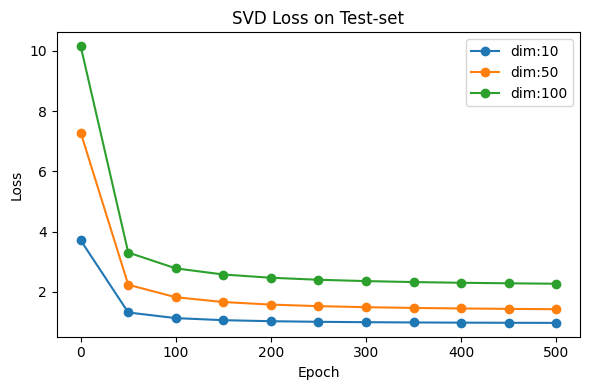

In [173]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, svd_test_rmse_dim10, label=f"dim:10", marker='o')
plt.plot(epochs, svd_test_rmse_dim50, label=f"dim:50", marker='o')
plt.plot(epochs, svd_test_rmse_dim100, label=f"dim:100", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"SVD Loss on Test-set")

plt.legend()

plt.tight_layout()
plt.show()

### NSVD

In [103]:
class NSVD(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, dim = 10, lam_u=0.01):
        super().__init__()
        self.lam_u = lam_u
        self.matrix = matrix
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.movie_weight = nn.Parameter(torch.randn(n_movies, dim))
        self.movie_features = nn.Parameter(torch.randn(n_movies, dim))
        self.non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        self.non_zero_sum = torch.sum(self.non_zero_mask, 1).unsqueeze(1)
    
    def forward(self, except_bl = False):
        baseline_matrix = self.baseline()
        user_rated_matrix = torch.matmul(self.non_zero_mask/self.non_zero_sum**(1/2), self.movie_weight)
        feature_matrix = torch.matmul(user_rated_matrix, self.movie_features.T)
        
        if except_bl :
            return feature_matrix

        prediction = baseline_matrix + feature_matrix 
        return prediction
    
    def loss(self, prediction):
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.non_zero_mask)
        u_regularization = self.lam_u * (torch.sum(self.baseline.user_bias.norm(p=2)) + torch.sum(self.baseline.movie_bias.norm(p=2)) + torch.sum(self.movie_weight.norm(p=2)) + torch.sum(self.movie_features.norm(p=2)))
        
        return prediction_error + u_regularization 

In [104]:
nsvd = NSVD(overall_mean, train_data, n_users, n_movies)
optimizer = torch.optim.SGD(nsvd.parameters(), lr=5e-6)

nsvd_train_rmse_dim10, nsvd_test_rmse_dim10 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = nsvd()
    loss = nsvd.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        nsvd_train_rmse_dim10.append(RMSE(out,train_data))
        nsvd_test_rmse_dim10.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 11340435.000
Step 50, 4599090.500
Step 100, 3274663.500
Step 150, 2600796.750
Step 200, 2193244.750
Step 250, 1921288.625
Step 300, 1727676.750
Step 350, 1583305.875
Step 400, 1471818.750
Step 450, 1383327.000
Step 500, 1311511.375


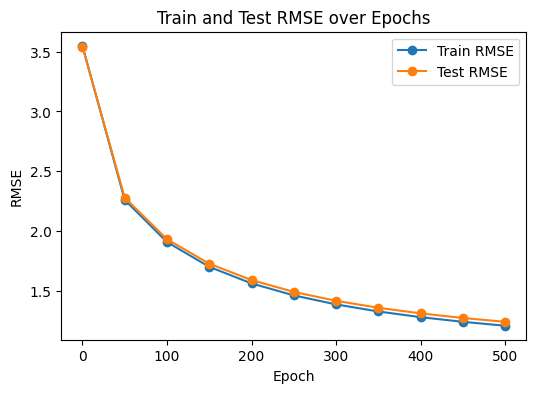

In [105]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, nsvd_train_rmse_dim10, label='Train RMSE', marker='o')
plt.plot(epochs, nsvd_test_rmse_dim10, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [ ]:
nsvd_test_rmse_dim10

In [107]:
nsvd = NSVD(overall_mean, train_data, n_users, n_movies, dim=50)
optimizer = torch.optim.SGD(nsvd.parameters(), lr=5e-6)

nsvd_train_rmse_dim50, nsvd_test_rmse_dim50 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = nsvd()
    loss = nsvd.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        nsvd_train_rmse_dim50.append(RMSE(out,train_data))
        nsvd_test_rmse_dim50.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 52056748.000
Step 50, 13508381.000
Step 100, 8750949.000
Step 150, 6484098.000
Step 200, 5156394.000
Step 250, 4290023.500
Step 300, 3683294.000
Step 350, 3236492.250
Step 400, 2894810.750
Step 450, 2625716.250
Step 500, 2408724.750


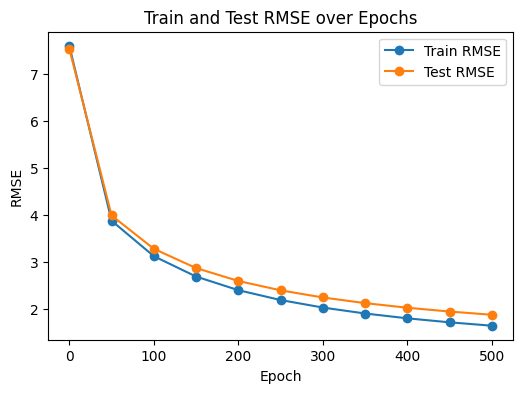

In [108]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, nsvd_train_rmse_dim50, label='Train RMSE', marker='o')
plt.plot(epochs, nsvd_test_rmse_dim50, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [110]:
nsvd = NSVD(overall_mean, train_data, n_users, n_movies, dim=100)
optimizer = torch.optim.SGD(nsvd.parameters(), lr=5e-6)

nsvd_train_rmse_dim100, nsvd_test_rmse_dim100 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = nsvd()
    loss = nsvd.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        nsvd_train_rmse_dim100.append(RMSE(out,train_data))
        nsvd_test_rmse_dim100.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 97311048.000
Step 50, 25592496.000
Step 100, 14547096.000
Step 150, 10515653.000
Step 200, 8180649.500
Step 250, 6669497.000
Step 300, 5618275.000
Step 350, 4848519.000
Step 400, 4262776.500
Step 450, 3803513.000
Step 500, 3434673.000


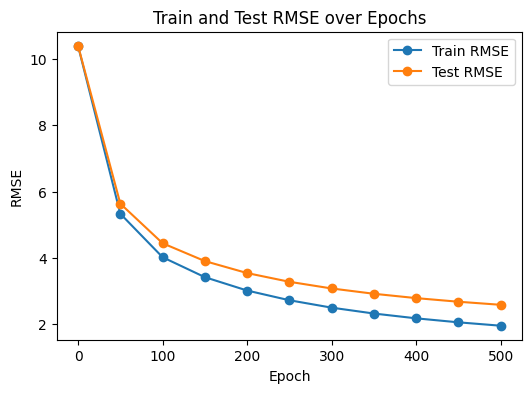

In [111]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, nsvd_train_rmse_dim100, label='Train RMSE', marker='o')
plt.plot(epochs, nsvd_test_rmse_dim100, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [112]:
nsvd_test_rmse_dim10, nsvd_test_rmse_dim50, nsvd_test_rmse_dim100

([array(3.542546, dtype=float32),
  array(2.2783735, dtype=float32),
  array(1.9308151, dtype=float32),
  array(1.7259657, dtype=float32),
  array(1.5888366, dtype=float32),
  array(1.4901059, dtype=float32),
  array(1.4155033, dtype=float32),
  array(1.3571324, dtype=float32),
  array(1.3102311, dtype=float32),
  array(1.2717422, dtype=float32),
  array(1.2396082, dtype=float32)],
 [array(7.543364, dtype=float32),
  array(3.985507, dtype=float32),
  array(3.275131, dtype=float32),
  array(2.864904, dtype=float32),
  array(2.5896258, dtype=float32),
  array(2.3899853, dtype=float32),
  array(2.2376447, dtype=float32),
  array(2.117104, dtype=float32),
  array(2.0190854, dtype=float32),
  array(1.9376596, dtype=float32),
  array(1.868845, dtype=float32)],
 [array(10.399821, dtype=float32),
  array(5.6355467, dtype=float32),
  array(4.441332, dtype=float32),
  array(3.9030008, dtype=float32),
  array(3.5414956, dtype=float32),
  array(3.278507, dtype=float32),
  array(3.0770195, dtype=fl

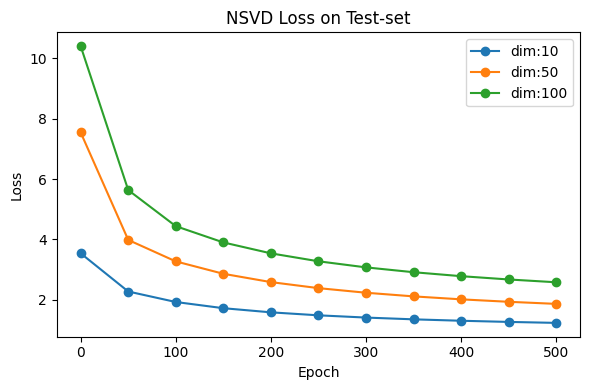

In [170]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, nsvd_test_rmse_dim10, label=f"dim:10", marker='o')
plt.plot(epochs, nsvd_test_rmse_dim50, label=f"dim:50", marker='o')
plt.plot(epochs, nsvd_test_rmse_dim100, label=f"dim:100", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"NSVD Loss on Test-set")

plt.legend()

plt.tight_layout()
plt.show()

# Improvement

## Revised Neighborhood Model 

In [113]:
class Improved_Neighborhood(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, pearson_coefficient, top_k=10, lam_u=0.01):
        super().__init__()
        self.matrix = matrix
        self.lam_u = lam_u
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.top_k = top_k
        self.pearson_coefficient = pearson_coefficient
        self.shrunk_coeff = get_shrunk_coefficient(self.pearson_coefficient, get_rated_both_items(matrix), 100) # default value 
        self.topk_matrix, self.topk_sigma = get_neighborhood(self.shrunk_coeff, top_k)
        self.non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        self.item_weight = nn.Parameter(torch.rand(n_movies, n_movies))
        self.item_implicit = nn.Parameter(torch.rand(n_movies, n_movies))

    def forward(self, except_bl = False):
        baseline_matrix = self.baseline()
        non_zero_sum = torch.sum(self.topk_matrix, 1).unsqueeze(1)

        diff_matrix = self.matrix - baseline_matrix # r_uj - b_uj
        feature_matrix = torch.matmul(diff_matrix, torch.mul(self.topk_matrix / non_zero_sum**(1/2), self.item_weight).T )  + torch.matmul(torch.ones(n_users, n_movies), torch.mul(self.topk_matrix/ non_zero_sum ** (1/2), self.item_implicit).T)

        if except_bl : 
            return feature_matrix

        prediction = baseline_matrix + feature_matrix 

        return prediction
    
    def loss(self, prediction):
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.non_zero_mask)
        l2_reg = self.lam_u * (self.baseline.user_bias.norm(p=2) + self.baseline.movie_bias.norm(p=2) + self.item_implicit.norm(p=2) + self.item_weight.norm(p=2))
        total_loss = prediction_error + l2_reg
        
        return total_loss

In [115]:
revised_ngbr = Improved_Neighborhood(overall_mean, train_data, n_users, n_movies, corr)
optimizer = torch.optim.SGD(revised_ngbr.parameters(), lr=5e-6)

rvd_train_rmse_k10, rvd_test_rmse_k10 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = revised_ngbr()
    loss = revised_ngbr.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        rvd_train_rmse_k10.append(RMSE(out,train_data))
        rvd_test_rmse_k10.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 18068512.000
Step 50, 2009768.625
Step 100, 1648449.875
Step 150, 1503456.875
Step 200, 1411144.000
Step 250, 1341722.750
Step 300, 1285378.125
Step 350, 1237716.750
Step 400, 1196381.000
Step 450, 1159947.375
Step 500, 1127480.875


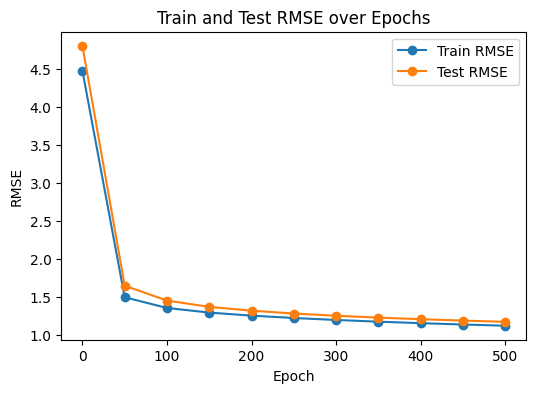

In [117]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, rvd_train_rmse_k10, label='Train RMSE', marker='o')
plt.plot(epochs, rvd_test_rmse_k10, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [118]:
revised_ngbr = Improved_Neighborhood(overall_mean, train_data, n_users, n_movies, corr, top_k=50)
optimizer = torch.optim.SGD(revised_ngbr.parameters(), lr=5e-6)

rvd_train_rmse_k50, rvd_test_rmse_k50 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = revised_ngbr()
    loss = revised_ngbr.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        rvd_train_rmse_k50.append(RMSE(out,train_data))
        rvd_test_rmse_k50.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 77132192.000
Step 50, 3726218.750
Step 100, 2520666.750
Step 150, 2083193.375
Step 200, 1848348.625
Step 250, 1698331.000
Step 300, 1592274.500
Step 350, 1512110.375
Step 400, 1448566.875
Step 450, 1396377.875
Step 500, 1352326.500


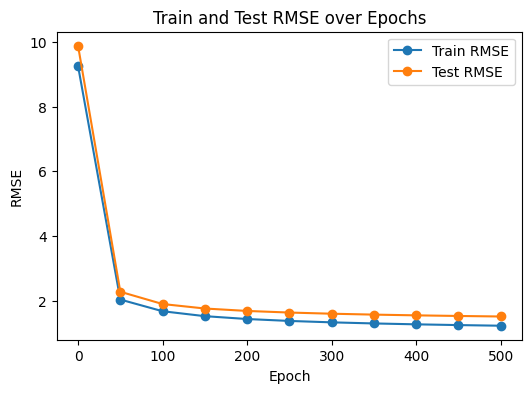

In [119]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, rvd_train_rmse_k50, label='Train RMSE', marker='o')
plt.plot(epochs, rvd_test_rmse_k50, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [120]:
revised_ngbr = Improved_Neighborhood(overall_mean, train_data, n_users, n_movies, corr, top_k=100)
optimizer = torch.optim.SGD(revised_ngbr.parameters(), lr=5e-6)

rvd_train_rmse_k100, rvd_test_rmse_k100 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = revised_ngbr()
    loss = revised_ngbr.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        rvd_train_rmse_k100.append(RMSE(out,train_data))
        rvd_test_rmse_k100.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 149832240.000
Step 50, 4615380.000
Step 100, 2816720.000
Step 150, 2199490.500
Step 200, 1886488.750
Step 250, 1695980.500
Step 300, 1566737.000
Step 350, 1472465.875
Step 400, 1400048.375
Step 450, 1342221.000
Step 500, 1294641.625


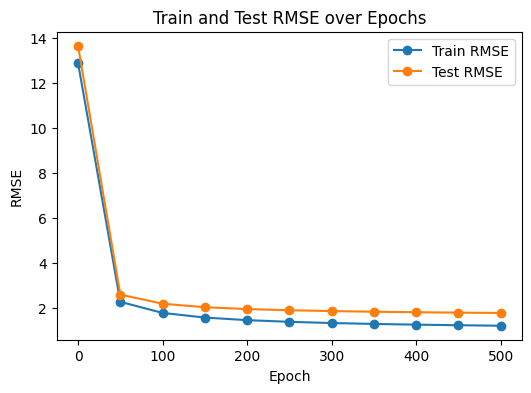

In [121]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, rvd_train_rmse_k100, label='Train RMSE', marker='o')
plt.plot(epochs, rvd_test_rmse_k100, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


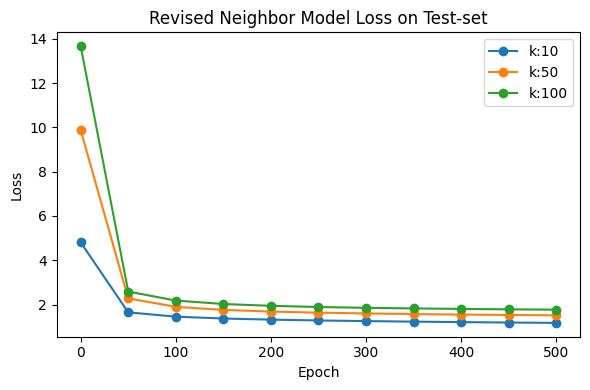

In [174]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, rvd_test_rmse_k10, label=f"k:10", marker='o')
plt.plot(epochs, rvd_test_rmse_k50, label=f"k:50", marker='o')
plt.plot(epochs, rvd_test_rmse_k100, label=f"k:100", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"Revised Neighbor Model Loss on Test-set")

plt.legend()

plt.tight_layout()
plt.show()

In [175]:
rvd_test_rmse_k10, rvd_test_rmse_k50, rvd_test_rmse_k100

([array(4.8089275, dtype=float32),
  array(1.646893, dtype=float32),
  array(1.4504135, dtype=float32),
  array(1.367926, dtype=float32),
  array(1.3171276, dtype=float32),
  array(1.2801313, dtype=float32),
  array(1.2507526, dtype=float32),
  array(1.2262421, dtype=float32),
  array(1.2051657, dtype=float32),
  array(1.186687, dtype=float32),
  array(1.1702743, dtype=float32)],
 [array(9.881869, dtype=float32),
  array(2.275254, dtype=float32),
  array(1.896219, dtype=float32),
  array(1.7577418, dtype=float32),
  array(1.6823785, dtype=float32),
  array(1.6329172, dtype=float32),
  array(1.5969092, dtype=float32),
  array(1.5689418, dtype=float32),
  array(1.5462352, dtype=float32),
  array(1.5271951, dtype=float32),
  array(1.510832, dtype=float32)],
 [array(13.668555, dtype=float32),
  array(2.5856652, dtype=float32),
  array(2.1786468, dtype=float32),
  array(2.0235758, dtype=float32),
  array(1.9406492, dtype=float32),
  array(1.8880672, dtype=float32),
  array(1.8509979, dtype=

## Latent Factor Models Revised

### Asymmetric-SVD

In [123]:
class AsymmetricSVD(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, dim=10, lam_u=0.01):
        super().__init__()
        self.lam_u = lam_u
        self.matrix = matrix
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.none_zero_mask = (self.matrix != -1).type(torch.FloatTensor)
        self.non_zero_sum = torch.sum(self.none_zero_mask, 1).unsqueeze(1)
        self.movie_weight = nn.Parameter(torch.randn(n_movies, dim))
        self.movie_features = nn.Parameter(torch.randn(n_movies, dim))
        self.implicit_feedback = nn.Parameter(torch.rand(n_movies, dim))

    def forward(self, except_bl = False):
        baseline_matrix = baseline()
        
        user_rated_matrix = torch.matmul(self.none_zero_mask, self.movie_weight) / self.non_zero_sum**(1/2) + torch.matmul(self.none_zero_mask, self.implicit_feedback) / self.non_zero_sum**(1/2)

        feature_matrix = torch.matmul(user_rated_matrix, self.movie_features.T)
        
        if except_bl:
            return feature_matrix

        prediction = baseline_matrix + feature_matrix
        return prediction
    
    def loss(self, prediction): 
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.none_zero_mask)

        u_regularization = self.lam_u * (torch.sum(self.baseline.user_bias.norm(p=2)) + torch.sum(self.baseline.movie_bias.norm(p=2)) + torch.sum(self.movie_weight.norm(p=2)) + torch.sum(self.movie_features.norm(p=2)) + torch.sum(self.implicit_feedback.norm(p=2)))
        
        return prediction_error + u_regularization 

In [125]:
asymmetricSVD = AsymmetricSVD(overall_mean, train_data, n_users, n_movies)
optimizer = torch.optim.SGD(asymmetricSVD.parameters(), lr=5e-7)

asymm_train_rmse_dim10, asymm_test_rmse_dim10 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = asymmetricSVD()
    loss = asymmetricSVD.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        asymm_train_rmse_dim10.append(RMSE(out,train_data))
        asymm_test_rmse_dim10.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 824070528.000
Step 50, 7560878.000
Step 100, 5906026.500
Step 150, 5039278.500
Step 200, 4442146.500
Step 250, 3994474.750
Step 300, 3642758.000
Step 350, 3357685.250
Step 400, 3121332.500
Step 450, 2921928.500
Step 500, 2751330.500


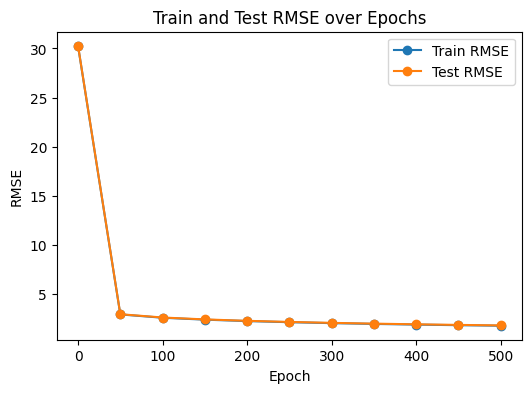

In [126]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, asymm_train_rmse_dim10, label='Train RMSE', marker='o')
plt.plot(epochs, asymm_test_rmse_dim10, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [137]:
asymmetricSVD = AsymmetricSVD(overall_mean, train_data, n_users, n_movies, dim=50)
optimizer = torch.optim.SGD(asymmetricSVD.parameters(), lr=5e-7)

asymm_train_rmse_dim50, asymm_test_rmse_dim50 = [], []
max_norm = 1000000

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = asymmetricSVD()
    loss = asymmetricSVD.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(asymmetricSVD.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        asymm_train_rmse_dim50.append(RMSE(out,train_data))
        asymm_test_rmse_dim50.append(RMSE(out, test_data)) 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 3886438400.000
Step 50, 829542208.000
Step 100, 128566024.000
Step 150, 34682008.000
Step 200, 29081406.000
Step 250, 26217582.000
Step 300, 24169324.000
Step 350, 22530748.000
Step 400, 21150606.000
Step 450, 19954532.000
Step 500, 18899166.000


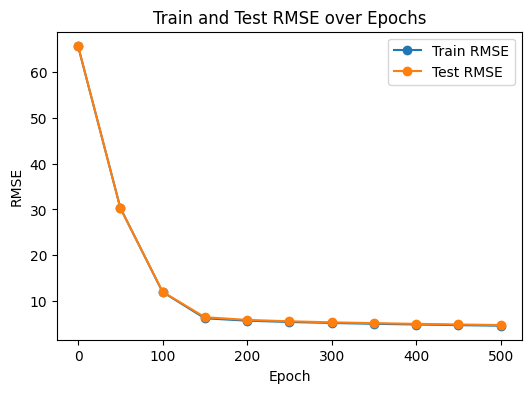

In [138]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, asymm_train_rmse_dim50, label='Train RMSE', marker='o')
plt.plot(epochs, asymm_test_rmse_dim50, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [178]:
asymmetricSVD = AsymmetricSVD(overall_mean, train_data, n_users, n_movies, dim=100)
optimizer = torch.optim.SGD(asymmetricSVD.parameters(), lr=5e-7)

asymm_train_rmse_dim100, asymm_test_rmse_dim100 = [], []
max_norm = 1000000

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = asymmetricSVD()
    loss = asymmetricSVD.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(asymmetricSVD.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        asymm_train_rmse_dim100.append(RMSE(out,train_data))
        asymm_test_rmse_dim100.append(RMSE(out, test_data)) 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 7775000064.000
Step 50, 1681988480.000
Step 100, 255390384.000
Step 150, 74878120.000
Step 200, 66036968.000
Step 250, 61544664.000
Step 300, 58322040.000
Step 350, 55738636.000
Step 400, 53551220.000
Step 450, 51637504.000
Step 500, 49926616.000


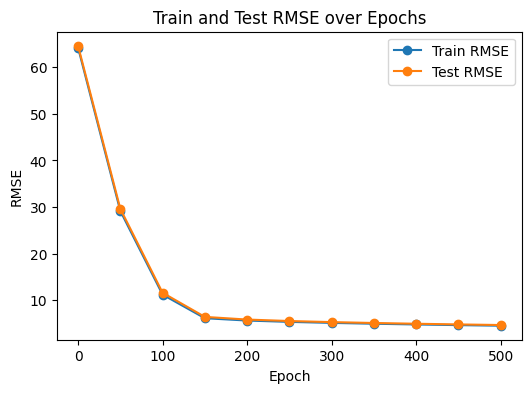

In [140]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, asymm_train_rmse_dim100, label='Train RMSE', marker='o')
plt.plot(epochs, asymm_test_rmse_dim100, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


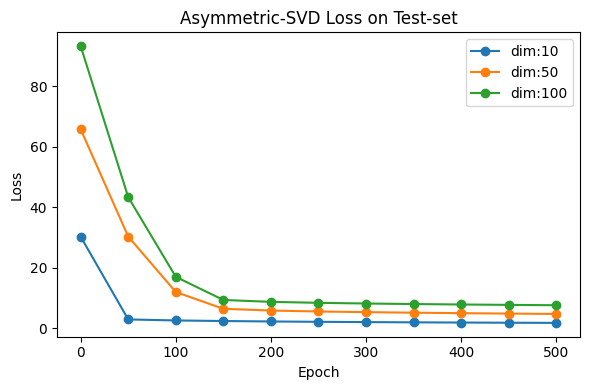

In [179]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, asymm_test_rmse_dim10, label=f"dim:10", marker='o')
plt.plot(epochs, asymm_test_rmse_dim50, label=f"dim:50", marker='o')
plt.plot(epochs, asymm_test_rmse_dim100, label=f"dim:100", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"Asymmetric-SVD Loss on Test-set")

plt.legend()

plt.tight_layout()
plt.show()

In [188]:
asymm_test_rmse_dim10, asymm_test_rmse_dim50, asymm_test_rmse_dim100

([array(30.279882, dtype=float32),
  array(2.9196506, dtype=float32),
  array(2.5850122, dtype=float32),
  array(2.3911777, dtype=float32),
  array(2.2477303, dtype=float32),
  array(2.1337602, dtype=float32),
  array(2.0396793, dtype=float32),
  array(1.9600493, dtype=float32),
  array(1.8914305, dtype=float32),
  array(1.8314886, dtype=float32),
  array(1.7785568, dtype=float32)],
 [array(65.79817, dtype=float32),
  array(30.313467, dtype=float32),
  array(11.991034, dtype=float32),
  array(6.4400983, dtype=float32),
  array(5.8577414, dtype=float32),
  array(5.5503526, dtype=float32),
  array(5.3279448, dtype=float32),
  array(5.147071, dtype=float32),
  array(4.9916916, dtype=float32),
  array(4.854147, dtype=float32),
  array(4.730112, dtype=float32)],
 [array(93.27045, dtype=float32),
  array(43.34824, dtype=float32),
  array(17.000782, dtype=float32),
  array(9.359843, dtype=float32),
  array(8.731853, dtype=float32),
  array(8.411245, dtype=float32),
  array(8.187066, dtype=flo

### SVD++

In [141]:
class SVDdoublePlus(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, dim=10, lam_u=0.01):
        super().__init__()
        self.lam_u = lam_u
        self.matrix = matrix
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.none_zero_mask = (self.matrix != -1).type(torch.FloatTensor)
        self.non_zero_sum = torch.sum(self.none_zero_mask, 1).unsqueeze(1)
        self.user_features = nn.Parameter(torch.rand(n_users, dim))
        self.movie_features = nn.Parameter(torch.randn(n_movies, dim))
        self.implicit_feedback = nn.Parameter(torch.rand(n_movies, dim))

    def forward(self, except_bl = False):
        baseline_matrix = baseline()
        
        user_rated_matrix =  torch.matmul(self.none_zero_mask, self.implicit_feedback) / self.non_zero_sum**(1/2) + self.user_features

        feature_matrix = torch.matmul(user_rated_matrix, self.movie_features.T)
        
        if except_bl:
            return feature_matrix

        prediction = baseline_matrix + feature_matrix
        return prediction
    
    def loss(self, prediction): 
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.none_zero_mask)

        u_regularization = self.lam_u * (torch.sum(self.baseline.user_bias.norm(p=2)) + torch.sum(self.baseline.movie_bias.norm(p=2)) + torch.sum(self.user_features.norm(p=2)) + torch.sum(self.movie_features.norm(p=2)) + torch.sum(self.implicit_feedback.norm(p=2)))
        
        return prediction_error + u_regularization 

In [144]:
svdplus = SVDdoublePlus(overall_mean, train_data, n_users, n_movies)
optimizer = torch.optim.SGD(svdplus.parameters(), lr=5e-7)

svdplus_train_rmse, svdplus_test_rmse = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = svdplus()
    loss = svdplus.loss(out)
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        svdplus_train_rmse.append(RMSE(out,train_data))
        svdplus_test_rmse.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 908262400.000
Step 50, 4877118.000
Step 100, 2855205.500
Step 150, 2261614.500
Step 200, 1977284.875
Step 250, 1805521.375
Step 300, 1686781.000
Step 350, 1597445.375
Step 400, 1526387.625
Step 450, 1467682.000
Step 500, 1417861.750


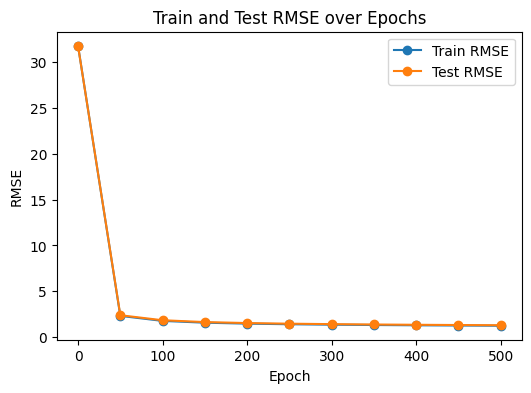

In [146]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, svdplus_train_rmse, label='Train RMSE', marker='o')
plt.plot(epochs, svdplus_test_rmse, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [148]:
svdplus = SVDdoublePlus(overall_mean, train_data, n_users, n_movies, dim=50)
optimizer = torch.optim.SGD(svdplus.parameters(), lr=5e-7)

svdplus_train_rmse_dim50, svdplus_test_rmse_dim50 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = svdplus()
    loss = svdplus.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(svdplus.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        svdplus_train_rmse_dim50.append(RMSE(out,train_data))
        svdplus_test_rmse_dim50.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 4355696128.000
Step 50, 930652416.000
Step 100, 103972160.000
Step 150, 11497617.000
Step 200, 8788388.000
Step 250, 7845520.000
Step 300, 7325253.500
Step 350, 6973291.000
Step 400, 6706751.500
Step 450, 6490278.500
Step 500, 6306235.500


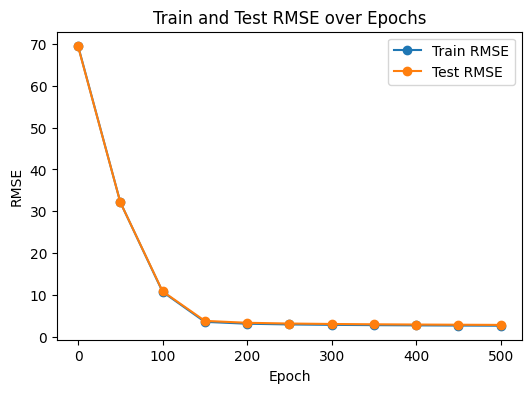

In [149]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, svdplus_train_rmse_dim50, label='Train RMSE', marker='o')
plt.plot(epochs, svdplus_test_rmse_dim50, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [150]:
svdplus = SVDdoublePlus(overall_mean, train_data, n_users, n_movies, dim=100)
optimizer = torch.optim.SGD(svdplus.parameters(), lr=5e-7)

svdplus_train_rmse_dim100, svdplus_test_rmse_dim100 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = svdplus()
    loss = svdplus.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(svdplus.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        svdplus_train_rmse_dim100.append(RMSE(out,train_data))
        svdplus_test_rmse_dim100.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 9356491776.000
Step 50, 2105962880.000
Step 100, 259360224.000
Step 150, 26604280.000
Step 200, 19089772.000
Step 250, 16723312.000
Step 300, 15529716.000
Step 350, 14785665.000
Step 400, 14259069.000
Step 450, 13853875.000
Step 500, 13523671.000


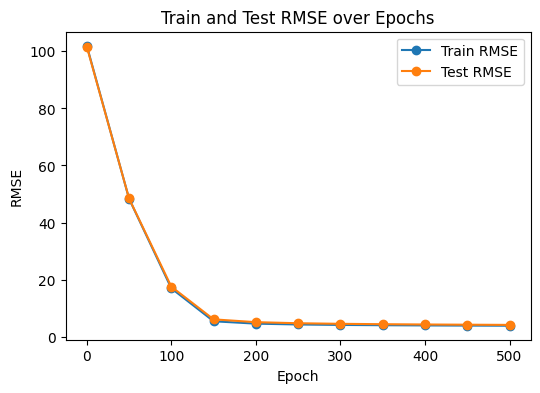

In [152]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, svdplus_train_rmse_dim100, label='Train RMSE', marker='o')
plt.plot(epochs, svdplus_test_rmse_dim100, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


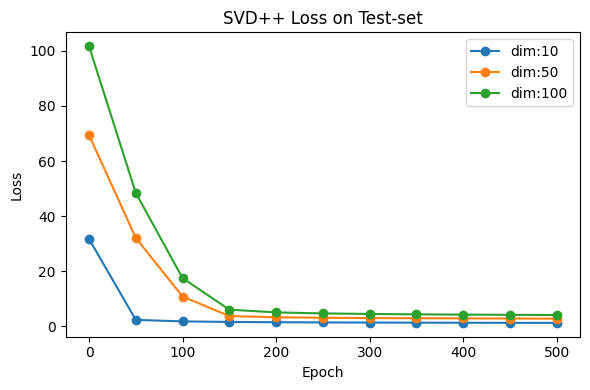

In [181]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, svdplus_test_rmse, label=f"dim:10", marker='o')
plt.plot(epochs, svdplus_test_rmse_dim50, label=f"dim:50", marker='o')
plt.plot(epochs, svdplus_test_rmse_dim100, label=f"dim:100", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"SVD++ Loss on Test-set")

plt.legend()

plt.tight_layout()
plt.show()

In [182]:
svdplus_test_rmse, svdplus_test_rmse_dim50, svdplus_test_rmse_dim100

([array(31.736858, dtype=float32),
  array(2.3976498, dtype=float32),
  array(1.8517512, dtype=float32),
  array(1.6524032, dtype=float32),
  array(1.5455934, dtype=float32),
  array(1.4765888, dtype=float32),
  array(1.4268254, dtype=float32),
  array(1.3883187, dtype=float32),
  array(1.3570677, dtype=float32),
  array(1.3308396, dtype=float32),
  array(1.308283, dtype=float32)],
 [array(69.41802, dtype=float32),
  array(32.149265, dtype=float32),
  array(10.86274, dtype=float32),
  array(3.8043542, dtype=float32),
  array(3.348511, dtype=float32),
  array(3.1705031, dtype=float32),
  array(3.0646787, dtype=float32),
  array(2.9894214, dtype=float32),
  array(2.9309728, dtype=float32),
  array(2.8831697, dtype=float32),
  array(2.8426926, dtype=float32)],
 [array(101.65161, dtype=float32),
  array(48.439274, dtype=float32),
  array(17.552174, dtype=float32),
  array(6.103663, dtype=float32),
  array(5.1198487, dtype=float32),
  array(4.747122, dtype=float32),
  array(4.542895, dtype=

# Integrated Model

In [154]:
class Integrated_Model(nn.Module):
    def __init__(self, overall, matrix, n_users, n_movies, pearson_coefficient, top_k=10, dim = 10, lam_u=0.01):
        super().__init__()
        self.matrix = matrix
        self.lam_u = lam_u
        self.dim = dim
        self.revised_ngbr = Improved_Neighborhood(overall, matrix, n_users, n_movies, pearson_coefficient)
        self.baseline = Baseline(overall, matrix, n_users, n_movies)
        self.svd_double_plus = SVDdoublePlus(overall, matrix, n_users, n_movies, self.dim)


    def forward(self):
        baseline_matrix = self.baseline()
        svd_matrix = self.svd_double_plus(except_bl = True)
        ngbr_matrix = self.revised_ngbr(except_bl = True)

        return baseline_matrix + svd_matrix + ngbr_matrix
    
    def loss(self, prediction):
        diff = (self.matrix - prediction)**2
        prediction_error = torch.sum(diff*self.svd_double_plus.none_zero_mask)

        u_regularization = self.lam_u * (torch.sum(self.baseline.user_bias.norm(p=2)) + torch.sum(self.baseline.movie_bias.norm(p=2)) + torch.sum(self.svd_double_plus.user_features.norm(p=2)) + torch.sum(self.svd_double_plus.movie_features.norm(p=2)) + torch.sum(self.svd_double_plus.implicit_feedback.norm(p=2)) + torch.sum(self.revised_ngbr.item_implicit.norm(p=2)) + torch.sum(self.revised_ngbr.item_weight.norm(p=2)) )
        return prediction_error + u_regularization 

In [155]:
integrated_model = Integrated_Model(overall_mean, train_data, n_users, n_movies, corr)
optimizer = torch.optim.SGD(integrated_model.parameters(), lr=5e-7)

ing_train_rmse_k10_d10, ing_test_rmsee_k10_d10 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = integrated_model()
    loss = integrated_model.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(integrated_model.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        ing_train_rmse_k10_d10.append(RMSE(out,train_data))
        ing_test_rmsee_k10_d10.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 863731776.000
Step 50, 11090767.000
Step 100, 7470553.500
Step 150, 5960006.000
Step 200, 5083214.500
Step 250, 4498766.000
Step 300, 4076809.250
Step 350, 3755403.500
Step 400, 3500848.750
Step 450, 3293138.750
Step 500, 3119615.750


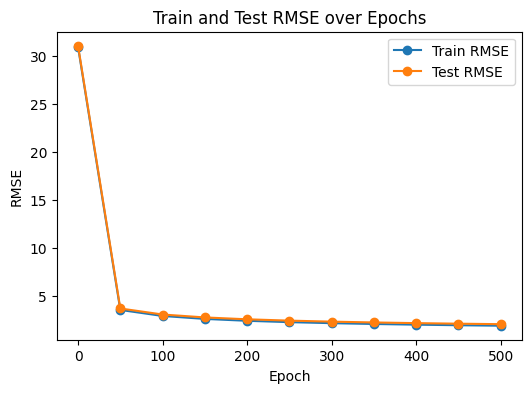

In [156]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, ing_train_rmse_k10_d10, label='Train RMSE', marker='o')
plt.plot(epochs, ing_test_rmsee_k10_d10, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [157]:
integrated_model = Integrated_Model(overall_mean, train_data, n_users, n_movies, corr, dim=50)
optimizer = torch.optim.SGD(integrated_model.parameters(), lr=5e-7)

ing_train_rmse_k10_d50, ing_test_rmsee_k10_d50 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = integrated_model()
    loss = integrated_model.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(integrated_model.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        ing_train_rmse_k10_d50.append(RMSE(out,train_data))
        ing_test_rmsee_k10_d50.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 4398473728.000
Step 50, 953068288.000
Step 100, 117712456.000
Step 150, 19590532.000
Step 200, 15850030.000
Step 250, 14215229.000
Step 300, 13139692.000
Step 350, 12323450.000
Step 400, 11661776.000
Step 450, 11104938.000
Step 500, 10624781.000


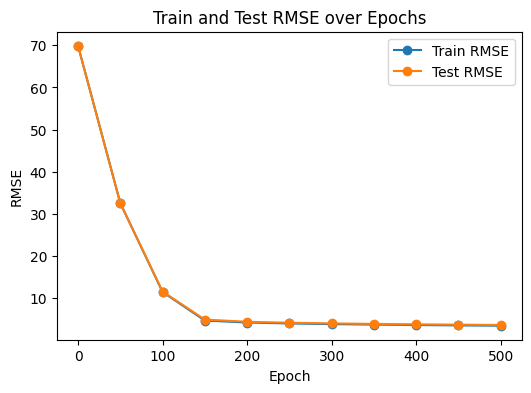

In [158]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, ing_train_rmse_k10_d50, label='Train RMSE', marker='o')
plt.plot(epochs, ing_test_rmsee_k10_d50, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


In [159]:
integrated_model = Integrated_Model(overall_mean, train_data, n_users, n_movies, corr, dim=100)
optimizer = torch.optim.SGD(integrated_model.parameters(), lr=5e-7)

ing_train_rmse_k10_d100, ing_test_rmsee_k10_d100 = [], []

for step, epoch in enumerate(range(501)):
    optimizer.zero_grad()
    out = integrated_model()
    loss = integrated_model.loss(out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(integrated_model.parameters(), max_norm)
    optimizer.step()
    if step % 50 == 0:
        ing_train_rmse_k10_d100.append(RMSE(out,train_data))
        ing_test_rmsee_k10_d100.append(RMSE(out, test_data)), 
        print(f"Step {step}, {loss:.3f}")
        

Step 0, 8874889216.000
Step 50, 1951278592.000
Step 100, 249275392.000
Step 150, 33650208.000
Step 200, 26553460.000
Step 250, 23973634.000
Step 300, 22481498.000
Step 350, 21427822.000
Step 400, 20604254.000
Step 450, 19921742.000
Step 500, 19334834.000


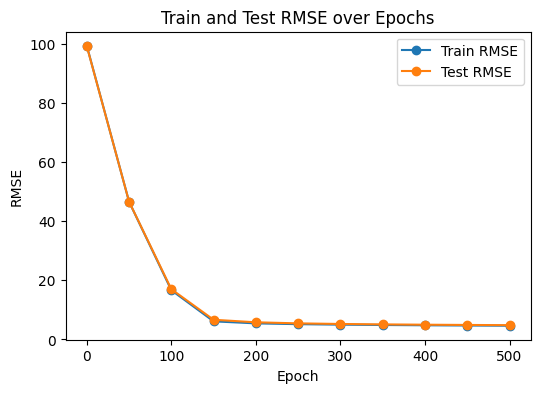

In [160]:
epochs = list(range(0, 501, 50)) 

plt.figure(figsize=(6, 4))
plt.plot(epochs, ing_train_rmse_k10_d100, label='Train RMSE', marker='o')
plt.plot(epochs, ing_test_rmsee_k10_d100, label='Test RMSE', marker='o')

plt.title('Train and Test RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.legend()

# 그리드 표시

# 그래프 표시
plt.show()


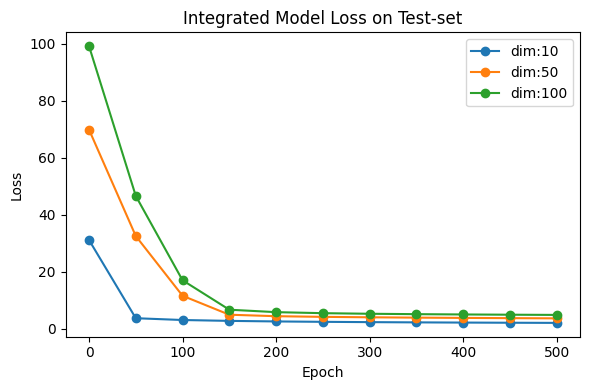

In [184]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, ing_test_rmsee_k10_d10, label=f"dim:10", marker='o')
plt.plot(epochs, ing_test_rmsee_k10_d50, label=f"dim:50", marker='o')
plt.plot(epochs, ing_test_rmsee_k10_d100, label=f"dim:100", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"Integrated Model Loss on Test-set")

plt.legend()

plt.tight_layout()
plt.show()

In [185]:
ing_test_rmsee_k10_d10, ing_test_rmsee_k10_d50, ing_test_rmsee_k10_d100

([array(31.106392, dtype=float32),
  array(3.662414, dtype=float32),
  array(3.0328999, dtype=float32),
  array(2.7273197, dtype=float32),
  array(2.532547, dtype=float32),
  array(2.393356, dtype=float32),
  array(2.2871377, dtype=float32),
  array(2.2024214, dtype=float32),
  array(2.1326349, dtype=float32),
  array(2.0737016, dtype=float32),
  array(2.0229475, dtype=float32)],
 [array(69.856476, dtype=float32),
  array(32.49731, dtype=float32),
  array(11.540001, dtype=float32),
  array(4.8900137, dtype=float32),
  array(4.373271, dtype=float32),
  array(4.139372, dtype=float32),
  array(3.9855535, dtype=float32),
  array(3.8677368, dtype=float32),
  array(3.7708952, dtype=float32),
  array(3.688174, dtype=float32),
  array(3.6157916, dtype=float32)],
 [array(99.15563, dtype=float32),
  array(46.57904, dtype=float32),
  array(16.979029, dtype=float32),
  array(6.64868, dtype=float32),
  array(5.7914658, dtype=float32),
  array(5.431778, dtype=float32),
  array(5.2250614, dtype=float

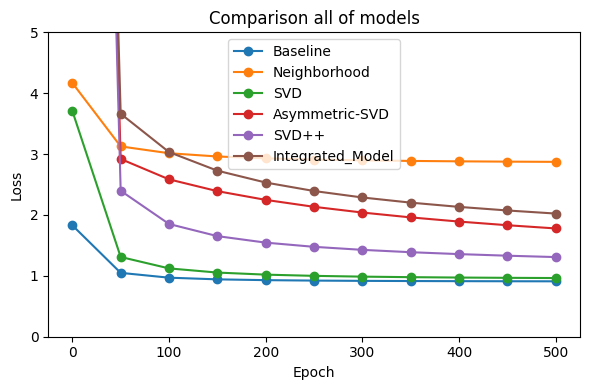

In [187]:
plt.style.use('default')



# 모든 실험의 손실 그래프 그리기
plt.figure(figsize=(6,4))
plt.title("Training Performance")

epochs = list(range(0, 501, 50)) 
plt.plot(epochs, bl_test_rmse, label=f"Baseline", marker='o')
plt.plot(epochs, corngbr_test_rmse, label=f"Neighborhood", marker='o')
plt.plot(epochs, svd_test_rmse_dim10, label=f"SVD", marker='o')
plt.plot(epochs, asymm_test_rmse_dim10, label=f"Asymmetric-SVD", marker='o')
plt.plot(epochs, svdplus_test_rmse, label=f"SVD++", marker='o')
plt.plot(epochs, ing_test_rmsee_k10_d10, label=f"Integrated_Model", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title(f"Comparison all of models")
plt.ylim(0, 5)
plt.legend()

plt.tight_layout()
plt.show()